# Multi-Label Classification with MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import os, sys
# sys.path.append(os.pardir)

from anime_classification import MultiLabelClassifier, Adam, Trainer

## Load Vectorized Synopsis/Genre Data

In [2]:
synop_vec = pd.read_csv('../synopsis_vector/synopsis_vector.csv')
synop_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1,-0.115356,-3.921875,0.509277,1.326172,2.687500,1.791992,-1.766602,-1.250977,-1.897461,...,0.864746,-0.738770,-1.119141,-0.729980,1.066406,1.272461,-0.246582,1.377930,1.923828,2.218750
1,5,2.314453,-2.361328,-0.011124,2.701172,1.198242,3.173828,-1.357422,-2.605469,-1.961914,...,0.493652,-0.946777,-0.941406,-0.263184,2.089844,1.500000,-0.221436,0.643066,2.216797,0.960449
2,6,-0.226196,-2.593750,-0.183350,2.042969,1.671875,1.951172,-1.369141,-2.914062,-0.160034,...,-1.435547,-1.023438,-2.533203,-2.453125,2.015625,1.945312,0.621094,1.706055,2.359375,1.230469
3,7,0.842773,-0.524902,0.272705,0.753906,1.575195,2.496094,-1.650391,-2.705078,-2.265625,...,-0.366943,-1.791016,-1.803711,-2.474609,2.876953,0.427734,-0.583496,3.105469,0.837891,1.042969
4,8,1.524414,-2.654297,0.425049,1.812500,2.027344,1.693359,0.608398,-1.334961,-1.022461,...,1.652344,-1.702148,-2.476562,-4.484375,1.406250,0.638672,0.057343,1.249023,2.455078,2.513672


In [3]:
genre_vec = pd.read_csv('../clean_data/genre.csv')
genre_vec.head()

,MAL_ID,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Harem,Hentai,Historical,...,Romance,School,Sci-Fi,Seinen,Shoujo,Shounen,Slice of Life,Sports,Super Power,Supernatural
0,1,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,5,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,6,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,7,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,8,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


## Split Train-Test Set

In [4]:
synop_cols = synop_vec.columns.drop('MAL_ID').values
genre_cols = genre_vec.columns.drop('MAL_ID').values

In [5]:
full_vec = pd.merge(synop_vec, genre_vec)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Romance,School,Sci-Fi,Seinen,Shoujo,Shounen,Slice of Life,Sports,Super Power,Supernatural
0,1,-0.115356,-3.921875,0.509277,1.326172,2.687500,1.791992,-1.766602,-1.250977,-1.897461,...,0,0,1,0,0,0,0,0,0,0
1,5,2.314453,-2.361328,-0.011124,2.701172,1.198242,3.173828,-1.357422,-2.605469,-1.961914,...,0,0,1,0,0,0,0,0,0,0
2,6,-0.226196,-2.593750,-0.183350,2.042969,1.671875,1.951172,-1.369141,-2.914062,-0.160034,...,0,0,1,0,0,1,0,0,0,0
3,7,0.842773,-0.524902,0.272705,0.753906,1.575195,2.496094,-1.650391,-2.705078,-2.265625,...,0,0,0,0,0,0,0,0,0,1
4,8,1.524414,-2.654297,0.425049,1.812500,2.027344,1.693359,0.608398,-1.334961,-1.022461,...,0,0,0,0,0,1,0,0,0,1


In [6]:
# random shuffle and re-index
full_vec = full_vec.sample(frac=1).reset_index(drop=True)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Romance,School,Sci-Fi,Seinen,Shoujo,Shounen,Slice of Life,Sports,Super Power,Supernatural
0,42476,1.458984,-0.591797,-0.284180,2.375000,1.500000,2.724609,-0.434814,-2.488281,-2.638672,...,0,0,0,0,0,0,0,0,0,0
1,2402,-0.830566,-0.351074,0.873535,0.672852,2.521484,2.886719,-1.848633,-0.337158,-0.441406,...,0,0,0,0,0,1,1,1,0,0
2,43007,1.434570,-2.542969,0.030487,1.039062,0.848633,2.320312,-1.260742,-2.248047,-0.051025,...,1,1,0,0,0,0,0,0,0,0
3,476,2.265625,-1.636719,1.176758,1.987305,1.779297,1.460938,-1.979492,-1.625000,-2.621094,...,1,0,0,0,0,0,0,1,0,1
4,5538,1.288086,1.600586,-1.173828,3.351562,1.021484,1.711914,-0.692871,-1.372070,-2.488281,...,0,0,0,0,0,1,1,0,0,1


In [7]:
# split dataframe to train-test numpy array
train_ratio = 0.95
num_train = int(len(full_vec) * train_ratio)

x_train = full_vec[synop_cols][:num_train].values
t_train = full_vec[genre_cols][:num_train].values
id_train = full_vec['MAL_ID'][num_train:].values

x_test = full_vec[synop_cols][num_train:].values
t_test = full_vec[genre_cols][num_train:].values
id_test = full_vec['MAL_ID'][num_train:].values

del synop_vec, genre_vec, full_vec

In [8]:
# standardization
x_train_mean = x_train.mean(axis=0)
x_train_std  = x_train.std(axis=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test  = (x_test  - x_train_mean) / x_train_std

## Define Model

In [9]:
input_size  = len(synop_cols)
output_size = len(genre_cols)

model = MultiLabelClassifier(input_size=input_size,
                             hidden_size_list=[50],
                             output_size=output_size,
                             use_dropout=True,
                             dropout_ratio=0.5,
                            #  use_batchnorm=True,
                             use_focal_loss=True,
                             focal_gamma=0.5)
model.summary()

------------------------------------------------------------
Affine(input_size=100, output_size=50, weight_init=he)
------------------------------------------------------------
Relu()
------------------------------------------------------------
Dropout(dropout_ratio=0.5)
------------------------------------------------------------
Affine(input_size=50, output_size=25, weight_init=xavier)
------------------------------------------------------------
FocalLoss(gamma=0.5)
------------------------------------------------------------


In [10]:
optimizer = Adam(lr=0.001)
trainer = Trainer(model, optimizer)

## Train Model

In [11]:
num_epochs = 20
batch_size = 100

trainer.fit(x_train, t_train, x_test, t_test, 
            max_epoch=num_epochs, 
            batch_size=batch_size)

| epoch   1 | time   0[s] | train loss 7.76 | val loss 7.88
| epoch   2 | time   0[s] | train loss 7.21 | val loss 7.33
| epoch   3 | time   0[s] | train loss 7.44 | val loss 7.58
| epoch   4 | time   0[s] | train loss 7.49 | val loss 7.66
| epoch   5 | time   1[s] | train loss 7.45 | val loss 7.64
| epoch   6 | time   1[s] | train loss 7.40 | val loss 7.61
| epoch   7 | time   1[s] | train loss 7.33 | val loss 7.58
| epoch   8 | time   1[s] | train loss 7.25 | val loss 7.51
| epoch   9 | time   1[s] | train loss 7.19 | val loss 7.47
| epoch  10 | time   2[s] | train loss 7.14 | val loss 7.44
| epoch  11 | time   2[s] | train loss 7.06 | val loss 7.38
| epoch  12 | time   2[s] | train loss 7.02 | val loss 7.34
| epoch  13 | time   2[s] | train loss 6.98 | val loss 7.32
| epoch  14 | time   2[s] | train loss 6.94 | val loss 7.30
| epoch  15 | time   3[s] | train loss 6.90 | val loss 7.27
| epoch  16 | time   3[s] | train loss 6.86 | val loss 7.23
| epoch  17 | time   3[s] | train loss 6

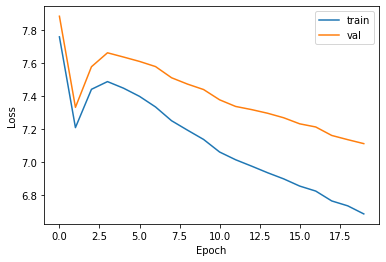

In [12]:
trainer.plot()

In [13]:
def print_prob(probs, labels):
    items = [x for x in sorted(zip(probs, genre_cols), reverse=True)]
    for (prob, genre), label in zip(items, labels):
        print('{:15s}{:>5.2f}% {}'.format(genre, prob*100, label))

In [14]:
num_show = 2
i_start = 0

y_train = model.predict(x_train)

for idx in range(i_start, num_show+i_start):
    print_prob(y_train[idx], t_train[idx])
    print()

Comedy         49.10% 0
Adventure      28.96% 1
Fantasy        21.39% 0
Action         19.30% 0
Shounen        15.75% 0
Kids           15.10% 0
Sci-Fi         13.73% 0
Drama           7.44% 0
Slice of Life   6.04% 0
Sports          5.83% 0
Historical      4.85% 1
Hentai          4.16% 0
Romance         3.75% 0
Mystery         3.57% 0
Mecha           3.14% 1
Supernatural    2.85% 0
Shoujo          2.52% 0
Seinen          2.49% 0
Ecchi           1.98% 0
School          1.88% 0
Music           1.71% 0
Horror          1.00% 0
Super Power     0.38% 0
Harem           0.16% 0
Military        0.15% 0

Comedy         42.40% 1
School         25.48% 0
Shounen        23.97% 0
Action         19.86% 1
Hentai         17.15% 0
Fantasy        16.47% 0
Romance        14.02% 0
Drama          13.00% 0
Adventure      12.48% 0
Slice of Life  12.33% 0
Supernatural   12.02% 0
Sports          6.82% 0
Sci-Fi          6.30% 0
Seinen          5.76% 0
Kids            5.02% 0
Shoujo          4.59% 0
Historical     

In [15]:
num_show = 10
i_start = 0

y_test = model.predict(x_test)

for idx in range(i_start, num_show+i_start):
    # print_prob(y_test[idx], t_test[idx])
    # print()

    mal_id = id_test[idx]
    
    predict = y_test[idx]>=0.5
    actual  = t_test[idx]==1

    TP = (actual & predict).sum()
    FP = (~actual & predict).sum()
    FN = (actual & ~predict).sum()
    TN = (~actual & ~predict).sum()
    
    print('{:^4} {:^4} {:^4} {:^4}'.format('T>T', 'F>T', 'T>F', 'F>F'))
    print('{:^4} {:^4} {:^4} {:^4}\n'.format(TP, FP, FN, TN))


    # print('{:^7} {:^7} {:^7} {:^7} {:^7}'.format('True', 'Pred', 'Correct', 'Wrong', 'Missed'))
    # print('{:^7} {:^7} {:^7} {:^7} {:^7}\n'.format(n_true, n_pred, n_correct, n_wrong, n_missed))

T>T  F>T  T>F  F>F 
 0    0    4    21 

T>T  F>T  T>F  F>F 
 1    0    2    22 

T>T  F>T  T>F  F>F 
 0    0    3    22 

T>T  F>T  T>F  F>F 
 0    0    5    20 

T>T  F>T  T>F  F>F 
 0    0    3    22 

T>T  F>T  T>F  F>F 
 0    0    3    22 

T>T  F>T  T>F  F>F 
 0    0    5    20 

T>T  F>T  T>F  F>F 
 0    0    3    22 

T>T  F>T  T>F  F>F 
 0    0    1    24 

T>T  F>T  T>F  F>F 
 0    0    4    21 

